In [1]:
#Importing Libraries
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL.ImageOps
import requests
from torch import nn
from torchvision import datasets, transforms
from PIL import Image

In [2]:
# Hyper Parameter settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 100
learning_rate = 0.0001
epochs = 18

In [3]:
#Downloading, Loading and Normalising dataset
# This is the two-step process used to prepare the
# data for use with the convolutional neural network.
# First step is to convert Python Image Library (PIL) format
# to PyTorch tensors.
# Second step is used to normalize the data by specifying a 
# mean and standard deviation for each of the three channels.
# This will convert the data from [0,1] to [-1,1]
# Normalization of data should help speed up conversion and
# reduce the chance of vanishing gradients with certain 
# activation functions.
# convert data to a normalized torch.FloatTensor

transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# choose the training and test datasets

train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

# prepare data loaders (combine dataset and sampler)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


In [4]:
class_names = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [5]:
# helper function to display an image
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

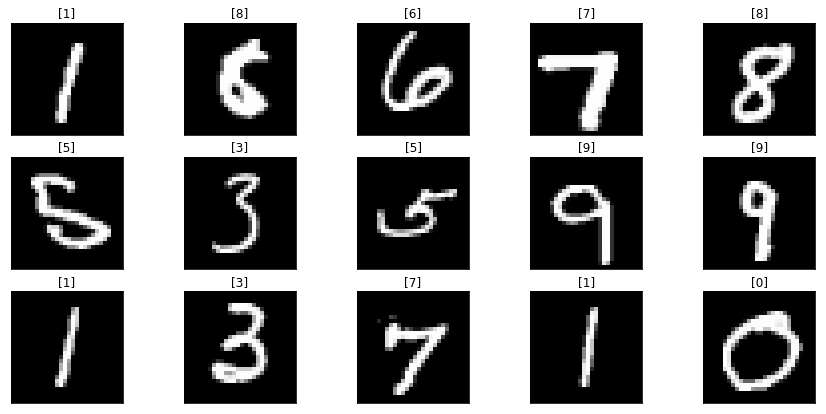

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(15, 7))

for idx in np.arange(15):
  ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title([labels[idx].item()])


In [7]:
# Defining the Convolutional Neural Network

class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
#Defining the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
#Training the Network
training_loss_history = []
training_corrects_history = []
val_loss_history = []
val_corrects_history = []
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  # train the model #

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  
  # validate the model 

  else:
    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(train_loader)#if batch size is 100
    #epoch_loss = running_loss/len(training_loader.dataset) #if batch size is not 100

    epoch_acc = running_corrects.float()/ len(train_loader) #if batch size is 100
    #epoch_acc = running_corrects.float()/ len(training_loader.dataset)  #if batch size is not 100

    training_loss_history.append(epoch_loss)
    training_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(val_loader) #if batch size is 100
    val_epoch_acc = val_running_corrects.float()/ len(val_loader) #if batch size is 100
    #val_epoch_loss = val_running_loss/len(validation_loader.dataset) #if batch size is not 100
    #val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset) #if batch size is not 100 
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.5900, acc 83.9917 
validation loss: 0.1832, validation acc 94.6800 
epoch : 2
training loss: 0.1495, acc 95.5450 
validation loss: 0.1048, validation acc 96.9700 
epoch : 3
training loss: 0.1008, acc 97.0183 
validation loss: 0.0805, validation acc 97.5100 
epoch : 4
training loss: 0.0774, acc 97.6800 
validation loss: 0.0635, validation acc 98.1200 
epoch : 5
training loss: 0.0644, acc 98.0417 
validation loss: 0.0542, validation acc 98.2800 
epoch : 6
training loss: 0.0556, acc 98.3850 
validation loss: 0.0477, validation acc 98.4900 
epoch : 7
training loss: 0.0492, acc 98.4933 
validation loss: 0.0457, validation acc 98.4700 
epoch : 8
training loss: 0.0443, acc 98.6450 
validation loss: 0.0370, validation acc 98.7900 
epoch : 9
training loss: 0.0397, acc 98.7900 
validation loss: 0.0368, validation acc 98.7800 
epoch : 10
training loss: 0.0362, acc 98.8983 
validation loss: 0.0360, validation acc 98.8600 
epoch : 11
training loss: 0.0335, acc 98.9883 
va

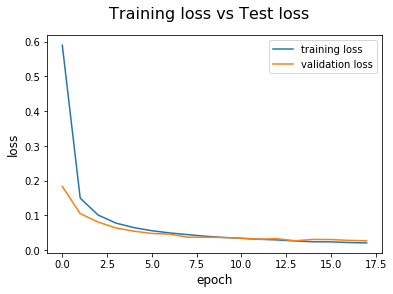

In [11]:
#plot the training and validation loss
plt.plot(training_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.suptitle('Training loss vs Test loss', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend()


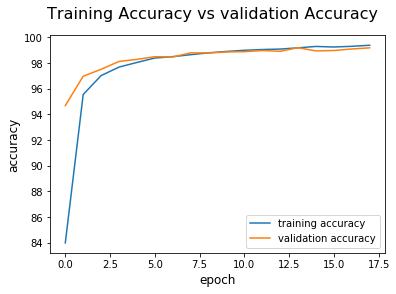

In [12]:
#plot the training and validation accuracy

plt.plot(training_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.suptitle('Training Accuracy vs validation Accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend()

In [13]:

#Predicting the Category for all Test Images
# Confusion_matrix

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 99.14%


In [14]:
#class_wise accuracy

print('{0:10s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} : {1:.1f}'.format(class_names[i], r[i]/np.sum(r)*100))

Category   : Accuracy
0          : 99.6
1          : 99.8
2          : 99.2
3          : 99.1
4          : 99.2
5          : 99.2
6          : 98.4
7          : 98.8
8          : 99.1
9          : 98.8


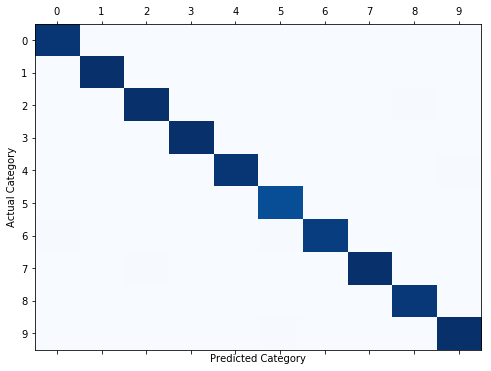

In [15]:
#plot confusion matrix

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), class_names)
plt.xlabel('Predicted Category')
plt.xticks(range(10), class_names)
plt.show()

In [16]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()


actual/pred     0         1         2         3         4         5         6         7         8         9         
0               976       0         0         0         0         0         1         1         1         1         
1               0         1133      0         0         0         0         1         0         0         1         
2               1         0         1024      0         0         0         0         3         4         0         
3               0         0         0         1001      0         3         0         3         3         0         
4               0         0         0         0         974       0         0         0         2         6         
5               1         0         0         3         0         885       1         1         1         0         
6               4         2         0         0         3         4         943       0         2         0         
7               0         3         5         1         0       

In [17]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     0         1         2         3         4         5         6         7         8         9         
0                               0.99591836734693870.0       0.0       0.0       0.0       0.0       0.00102040816326530620.00102040816326530620.00102040816326530620.0010204081632653062
1                               0.0       0.99823788546255510.0       0.0       0.0       0.0       0.0008810572687224670.0       0.0       0.000881057268722467
2                               0.00096899224806201550.0       0.99224806201550390.0       0.0       0.0       0.0       0.00290697674418604650.0038759689922480620.0       
3                               0.0       0.0       0.0       0.99108910891089110.0       0.00297029702970297030.0       0.00297029702970297030.00297029702970297030.0       
4                               0.0       0.0       0.0       0.0       0.99185336048879840.0       0.0       0.0       0.0020366598778004070.006109979633401222
5                            

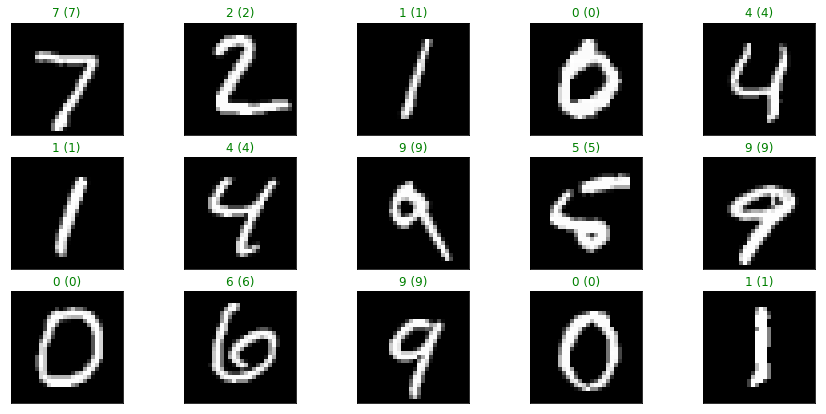

In [18]:
# plot the images in the batch, along with predicted and true labels
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(15, 7))

for idx in np.arange(15):
  ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

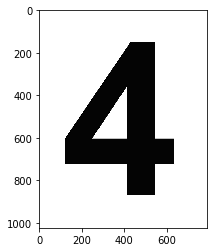

In [19]:
#test image from internet with the model 

url = 'https://vignette.wikia.nocookie.net/phobia/images/d/d0/4.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

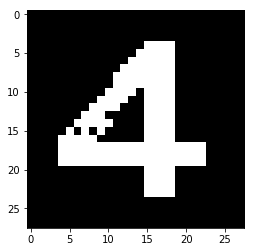

In [20]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(image_convert(img))

In [21]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

4
